In [1]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline

In [2]:
#%%
try:
    %load_ext autoreload
    %autoreload 2
    print 1
except:
    print 'NOT IPYTHON'

# import matplotlib as mpl
# mpl.use('TKAgg')
from matplotlib import pyplot as plt
# plt.ion()

import sys
import numpy as np
import ca_source_extraction as cse
from scipy.sparse import coo_matrix
import tifffile
from time import time
import psutil
from scipy.ndimage.filters import gaussian_filter

1


In [3]:
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
# import matplotlib.cm as cm

bpl.output_notebook()

Loading BokehJS ...

In [4]:
#%%
n_processes = np.maximum(np.int(psutil.cpu_count()*.75),1) # roughly number of cores on your machine minus 1
print 'using ' + str(n_processes) + ' processes'
print "Stopping  cluster to avoid unnencessary use of memory...."
sys.stdout.flush()  
cse.utilities.stop_server()

using 3 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
No cluster to stop... done


In [5]:
# try:
#     t = tifffile.TiffFile('movies/demoMovie3D.tif') 
# except:
#     # create 3d tiff
#     from scipy.io import loadmat
#     mat = loadmat('../ROI_detect/Datasets/data_exp3D')
#     data = np.transpose(mat['data'], [3, 0, 1, 2])
#     data -= data.min()
#     data *= (2**15-1)/data.max()
#     data = data.astype(np.uint16)
#     t = tifffile.TiffWriter('movies/demoMovie3D.tif', imagej=True)
#     t.save(np.transpose(data, [1, 0, 2, 3]))
#     t.close()
#     # change properties in ImageJ to 100 frames 1 channels and save changes

# Yr = t.asarray().astype(dtype=np.float32) 
# T, dims = Yr.shape[0], Yr.shape[1:]
# Yr = np.transpose(Yr, range(1,Yr.ndim)+[0])
# Yr=np.reshape(Yr,(np.prod(dims),T),order='F')

In [6]:
def gen_data(p = 1, noise=.2, T=100, framerate=30, firerate=2., plot=False):
    if p==2:
        gamma = np.array([1.5,-.55])
    elif p==1:
        gamma = np.array([.9])
    else: raise
    sz = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(4)  #3
    centers = np.asarray([[np.random.randint(5,x-5) 
                           for x in sz] for i in range(N)])
    data0 = np.zeros(sz + (T,))
    trueSpikes = np.random.rand(N,T) < firerate / float(framerate)
    trueSpikes[:,0] = 0
    truth = trueSpikes.astype(float)
    for i in range(2,T):
        if p ==2:
            truth[:,i] += gamma[0]*truth[:,i-1] + gamma[1]*truth[:,i-2] 
        else:
            truth[:,i] += gamma[0]*truth[:,i-1]
    for i in range(N):
        data0[centers[i,0],centers[i,1],centers[i,2]] = truth[i]
    tmp=np.zeros(sz)
    tmp[15,20,25]=1.
    z=np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(sz + (T,))) + 10 *gaussian_filter(data0, sig + (0,)) /z
    d1,d2,d3,T=Yr.shape
    Yr=np.reshape(Yr,(d1*d2*d3,T),order='F')
 
    if plot:
        Y=np.reshape(Yr,(d1,d2,d3,T),order='F')
        Cn = cse.utilities.local_correlations(Y)
        plt.figure(figsize=(15,3))
        plt.plot(truth.T);
        plt.figure(figsize=(15,3))
        for c in centers:
            plt.plot(Y[c[0],c[1],c[2]]);

        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1],c='g')
        plt.imshow(Y.max(0).max(-1),cmap='hot');plt.title('Max')
        plt.subplot(132)
        plt.scatter(*centers.T[[2,0,1]],c='g')
        plt.imshow(Y.max(1).max(-1),cmap='hot');plt.title('Max')
        plt.subplot(133)
        plt.scatter(*centers.T[[1,0,2]],c='g')
        plt.imshow(Y.max(2).max(-1),cmap='hot');plt.title('Max')

    return Yr, truth, trueSpikes, centers

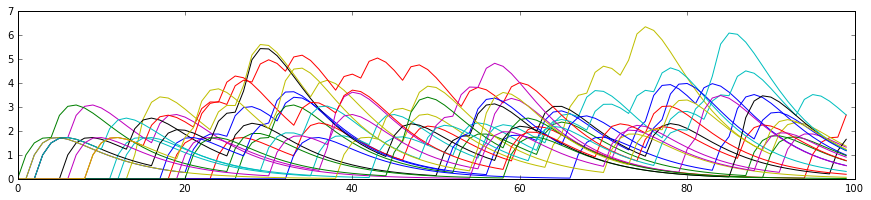

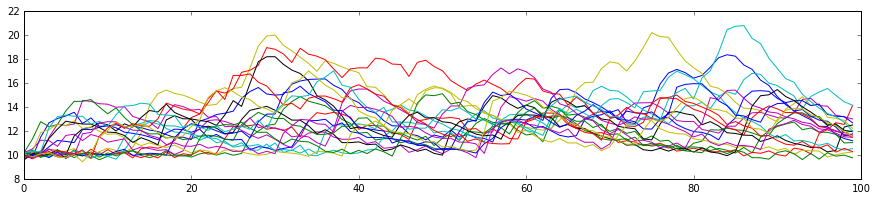

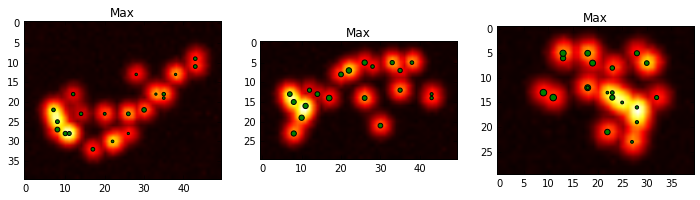

In [7]:
Yr, truth, trueSpikes, centers = gen_data(p=2,plot=True)

In [8]:
dims = (30, 40, 50); T=Yr.shape[1]

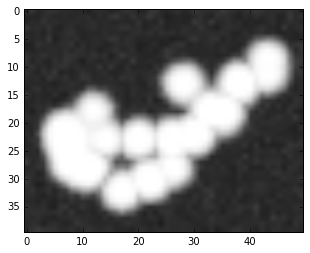

In [9]:
np.save('Yr',Yr)
Yr=np.load('Yr.npy',mmap_mode='r')  
# Yr,d1,d2,T=cse.utilities.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
Cn = cse.utilities.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape)==3 else Cn, cmap='gray',vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))    
plt.show()

In [10]:
#%%
K=20 # number of neurons expected per patch
gSig=[2,2,2] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system
options = cse.utilities.CNMFSetParms(Y,n_processes,p=p,gSig=gSig,K=K)
cse.utilities.start_server(options['spatial_params']['n_processes'])

using 3 processes
Starting cluster.................

In [11]:
options['spatial_params']['method'] = 'dilate'

In [12]:
#%% PREPROCESS DATA AND INITIALIZE COMPONENTS
t1 = time()
Yr,sn,g,psx = cse.pre_processing.preprocess_data(Yr,**options['preprocess_params'])
Atmp, Ctmp, b_in, f_in, center=cse.initialization.initialize_components(Y, **options['init_params'])                                                    
print time() - t1

Running on 3 engines.
Noise Normalization
Roi Extraction...
Refining Components...
3.24917387962


In [13]:
refine_components=False
if refine_components:
    Ain,Cin = cse.utilities.manually_refine_components(Y,options['init_params']['gSig'],coo_matrix(Atmp),Ctmp,Cn,thr=0.9)
else:
    Ain,Cin = Atmp, Ctmp

In [14]:
plt.close('all')

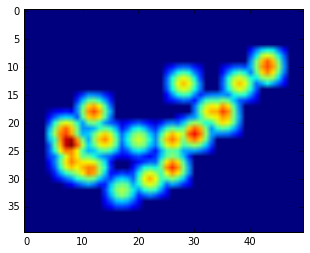

In [15]:
plt.figure()
plt.imshow(Ain.reshape(dims+(K,),order='F').max(0).max(-1));

In [16]:
p1=cse.nb_plot_contour(Cn.max(0),Ain.reshape(dims+(-1,),order='F').max(0).reshape((-1,K),order='F'),
                       dims[1],dims[2],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [17]:
#%% UPDATE SPATIAL COMPONENTS
t1 = time()
A,b,Cin = cse.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, **options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

 find search location
Updated Spatial Components
threshold
Computing A_bas
--- 11.1652989388 seconds ---
Remove temporary file created
11.1920289993
DONE!


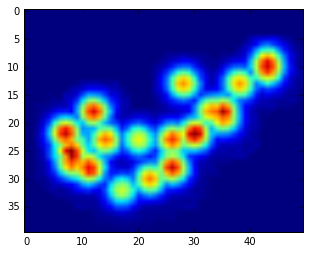

In [18]:
plt.imshow(A.toarray().reshape(dims+(K,),order='F').max(0).max(-1))

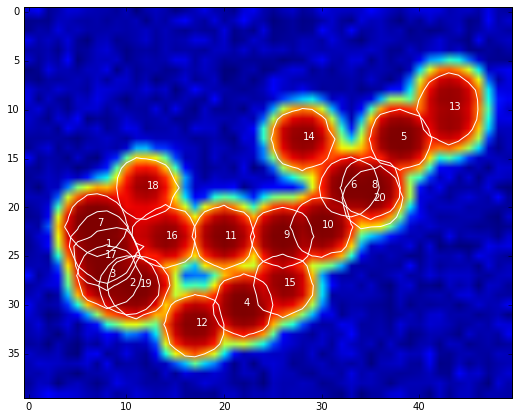

In [19]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = cse.utilities.plot_contours(
    A.toarray().reshape(dims+(-1,),order='F').max(0).reshape((np.prod(dims[1:]),-1),order='F'),
                       Cn.max(0),thr=0.9)
plt.show()

In [20]:
plt.close('all')

In [21]:
p1=cse.nb_plot_contour(Cn.max(0),A.toarray().reshape(dims+(-1,),order='F').max(0).reshape((np.prod(dims[1:]),-1),order='F'),
                       dims[1],dims[2],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [22]:
plt.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,f,S,bl,c1,neurons_sn,g,YrA = cse.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print t_elTEMPORAL  
clear_output(wait=True)

1 out of total 20 temporal components updated
2 out of total 20 temporal components updated
3 out of total 20 temporal components updated
5 out of total 20 temporal components updated
7 out of total 20 temporal components updated
10 out of total 20 temporal components updated
12 out of total 20 temporal components updated
14 out of total 20 temporal components updated
16 out of total 20 temporal components updated
20 out of total 20 temporal components updated
1 out of total 20 temporal components updated
3 out of total 20 temporal components updated
6 out of total 20 temporal components updated
9 out of total 20 temporal components updated
12 out of total 20 temporal components updated
14 out of total 20 temporal components updated
18 out of total 20 temporal components updated
20 out of total 20 temporal components updated
stopping: overall temporal component not changing significantly
0.405496120453


In [23]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cse.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'], bl=bl, c1=c1, sn=neurons_sn, g=g, thr=0.8, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print t_elMERGE  

********** No neurons merged! ***************
0.00428009033203


In [24]:
#refine spatial and temporal components
t1 = time()
A2,b2,C2 = cse.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
C2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cse.temporal.update_temporal_components(Yr,A2,b2,C2,f,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
print time() - t1
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

18.8042690754
DONE!


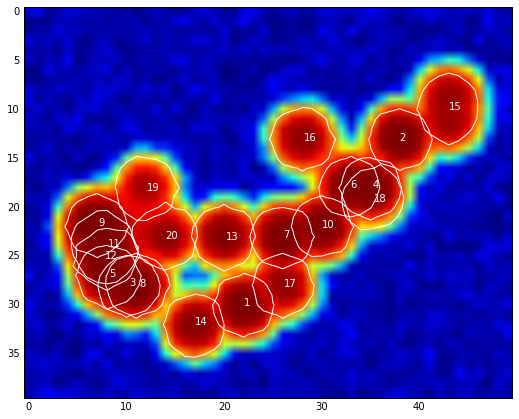

In [25]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
A_or, C_or, srt = cse.utilities.order_components(A2,C2)
crd = cse.utilities.plot_contours(coo_matrix(A_or.reshape(dims+(K,),order='F').max(0).reshape((-1, K),order='F')),
                                  Cn.max(0),thr=0.9)
plt.show()

In [26]:
p2=cse.utilities.nb_plot_contour(Cn.max(0),A_or.reshape(dims+(K,),order='F').max(0).reshape((-1, K),order='F'),dims[1],dims[2],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p2)

In [27]:
traces_fluo=cse.utilities.nb_view_patches(Yr.reshape(dims+(T,),order='F').max(0).reshape((-1,T),order='F'),
                                          A_or.reshape(dims+(K,),order='F').max(0).reshape((-1, K),order='F'),
                                          C_or,b2.reshape(dims+(1,),order='F').max(0).reshape((-1, 1),order='F'),
                                          f2,dims[1],dims[2],thr = 0.9,image_neurons=None)

Loading BokehJS ...

In [28]:
#%% STOP CLUSTER
cse.utilities.stop_server()

Stopping cluster...
Waiting for cluster to stop....... done
